In [1]:
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *
import math
from dataclasses import dataclass

mu_list = [2e-09, 6e-09, 2e-08, 6e-08, 2e-07]

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


# Get some realistic distribution of mu

In [2]:
freq_bin = 9
filename = os.path.join(KL_data_dir, f"whole_genome/freq_bins/freq_bin_{freq_bin}_all.tsv")

df = pd.read_csv(filename, sep = "\t")

df["mu_pergen"] = df["mu"]* per_generation_factor

log_mu_list = np.log10(mu_list)

log_mu_edges_list = log_mu_list[:-1] + np.diff(log_mu_list)/2
log_mu_edges_list = np.insert(log_mu_edges_list, 0, -10)
log_mu_edges_list = np.insert(log_mu_edges_list, len(log_mu_edges_list), -6)
mu_edges_list = np.power(10, log_mu_edges_list)

df["mu_bin"] = pd.cut(df["mu_pergen"], mu_edges_list, labels = mu_list)

df_proportions = df.groupby(["mu_bin"])[["sum"]].sum().reset_index()

df_proportions["prop"] = df_proportions["sum"]/df_proportions["sum"].sum()

In [3]:
df_proportions

,mu_bin,sum,prop
0,2.000000e-09,49461204.0,0.404226
1,6.000000e-09,50779472.0,0.415000
2,2.000000e-08,20885994.0,0.170693
3,6.000000e-08,593722.0,0.004852
4,2.000000e-07,639833.0,0.005229


# Define Functions

In [4]:
output_dir = "/home/djl34/kl_git/results"

@dataclass
class Power_Calculator:
    sample_size: int
    selection: float
    mu_index: int
    bin_number: int
    total_length: int
    transformation: str = "none"
    z_score_cutoff: float = 2.0
    type: str = "cdf"
    reverse: bool = True
    neutral_proportion: float = 0.0
    hypermutable_count: int = 0
    
    def calculate_power(self) -> (float, list):

        print(f"running analysis on type: {self.type},  window_length: {self.total_length}, s: {self.selection}")
        
        list_zscore = [self.get_score() for i in range(self.sample_size)]
        
        return sum(np.array(list_zscore) > self.z_score_cutoff)/self.sample_size, list_zscore

    def get_score(self) -> float:
    
        #for mu_index == -1, use the empirical distribution of mu
        if self.mu_index == -1:
            # first = True
    
            if self.hypermutable_count:
                total_length = self.total_length - self.hypermutable_count
            else:
                total_length = self.total_length
            #sample mu
            df_sample = df_proportions.sample(n = total_length, replace = True, weights = "prop")
            df_sample = pd.DataFrame(df_sample.groupby("mu_bin").size()).reset_index()

            rows = [self.get_sfs4mu(mu, df_sample) for mu in mu_list]
            neutral_sfs_all = np.concatenate([row[0] for row in rows], axis=0)
            data_array_all = np.concatenate([row[1] for row in rows], axis=0)
          
        else:
            mu = mu_list[self.mu_index]
            neutral_sfs_all, data_array_all = self.get_sfs(self.total_length, mu)
            
        winsfs_test = mlr.WinSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)
        
        if self.type == "Gnocchi":
            return winsfs_test.gnocchi()
        elif self.type == "ExtraINSIGHT":
            return winsfs_test.extrainsight()   
        elif self.type == "cdf":
            return winsfs_test.zscore_cdf(transformation = self.transformation, reverse = self.reverse)

    def get_sfs4mu(self, mu, df_sample) -> float:
        length = df_sample[df_sample["mu_bin"] == mu][0].item()
        
        if math.isclose(mu, 2.0e-07, rel_tol=1e-9, abs_tol=0.0):
            length += self.hypermutable_count

        return self.get_sfs(length, mu)


    def get_sfs(self, length, mu) -> float:
        file_prefix = "SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__"
        filename = os.path.join(output_dir, f"{file_prefix}-{self.selection}_mu_{mu}_bin_{self.bin_number}.npy")
        neutral_filename = os.path.join(output_dir, f"{file_prefix}-0.0_mu_{mu}_bin_{self.bin_number}.npy")
    
        sfs_array = np.load(filename)
        neutral_sfs = np.load(neutral_filename)
    
        #some mixture of neutral sites with certain proportions
        if self.neutral_proportion:
            #sample from bernoulli distribution with p = neutral_proportion
            neutral_length = np.random.binomial(n=length, p= self.neutral_proportion)
            non_neutral_length = length - neutral_length
    
            data_array = np.random.multinomial(non_neutral_length, sfs_array)[None, ...]
            neutral_data_array = np.random.multinomial(neutral_length, neutral_sfs)[None, ...]
            data_array += neutral_data_array
            
        else:
            data_array = np.random.multinomial(length, sfs_array)[None, ...]
        
        return neutral_sfs[None, ...], data_array

    def get_method_name(self):
        if (self.type == "Gnocchi") | (self.type == "ExtraINSIGHT"): 
            return self.type
        else:
            if self.transformation == "none":
                output_string = f"sum(p): {self.bin_number} bins"
            elif self.transformation == "log":
                output_string = f"sum(log(p)): {self.bin_number} bins"

            if self.reverse:
                output_string += " reverse"

        return output_string

    # def power_upper_bound(self) -> float:
        


# linear scale

## within 9 bins

In [5]:
selection_list = [0.0, 0.1, 0.03, 0.01]
window_length_list = [50, 150, 500, 1500]
reverse_list = [False, True]
neutral_proportion_list = [0.1 * x for x in range(10)]
bin_number_list = [9]
transformation_list = ["none", "log"]
mu_index_list = [-1]

window_num = 500

calculator_rows = [Power_Calculator(sample_size = window_num, selection=selection, mu_index = -1, bin_number = bin_number, 
                                    total_length = window_length, neutral_proportion = neutral_proportion, 
                                    transformation = transformation, reverse = reverse)
                  for window_length in window_length_list for neutral_proportion in neutral_proportion_list for selection in selection_list
                  for bin_number in bin_number_list for transformation in transformation_list for reverse in reverse_list]

neutral_prop_rows = [row.neutral_proportion for row in calculator_rows]
selection_rows = [row.selection for row in calculator_rows]
window_length_rows = [row.total_length for row in calculator_rows]
method_name_rows = [row.get_method_name() for row in calculator_rows]
output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(neutral_prop_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["Neutral Proportion", "selection", "window length", "method", "power"])

running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.0
runnin

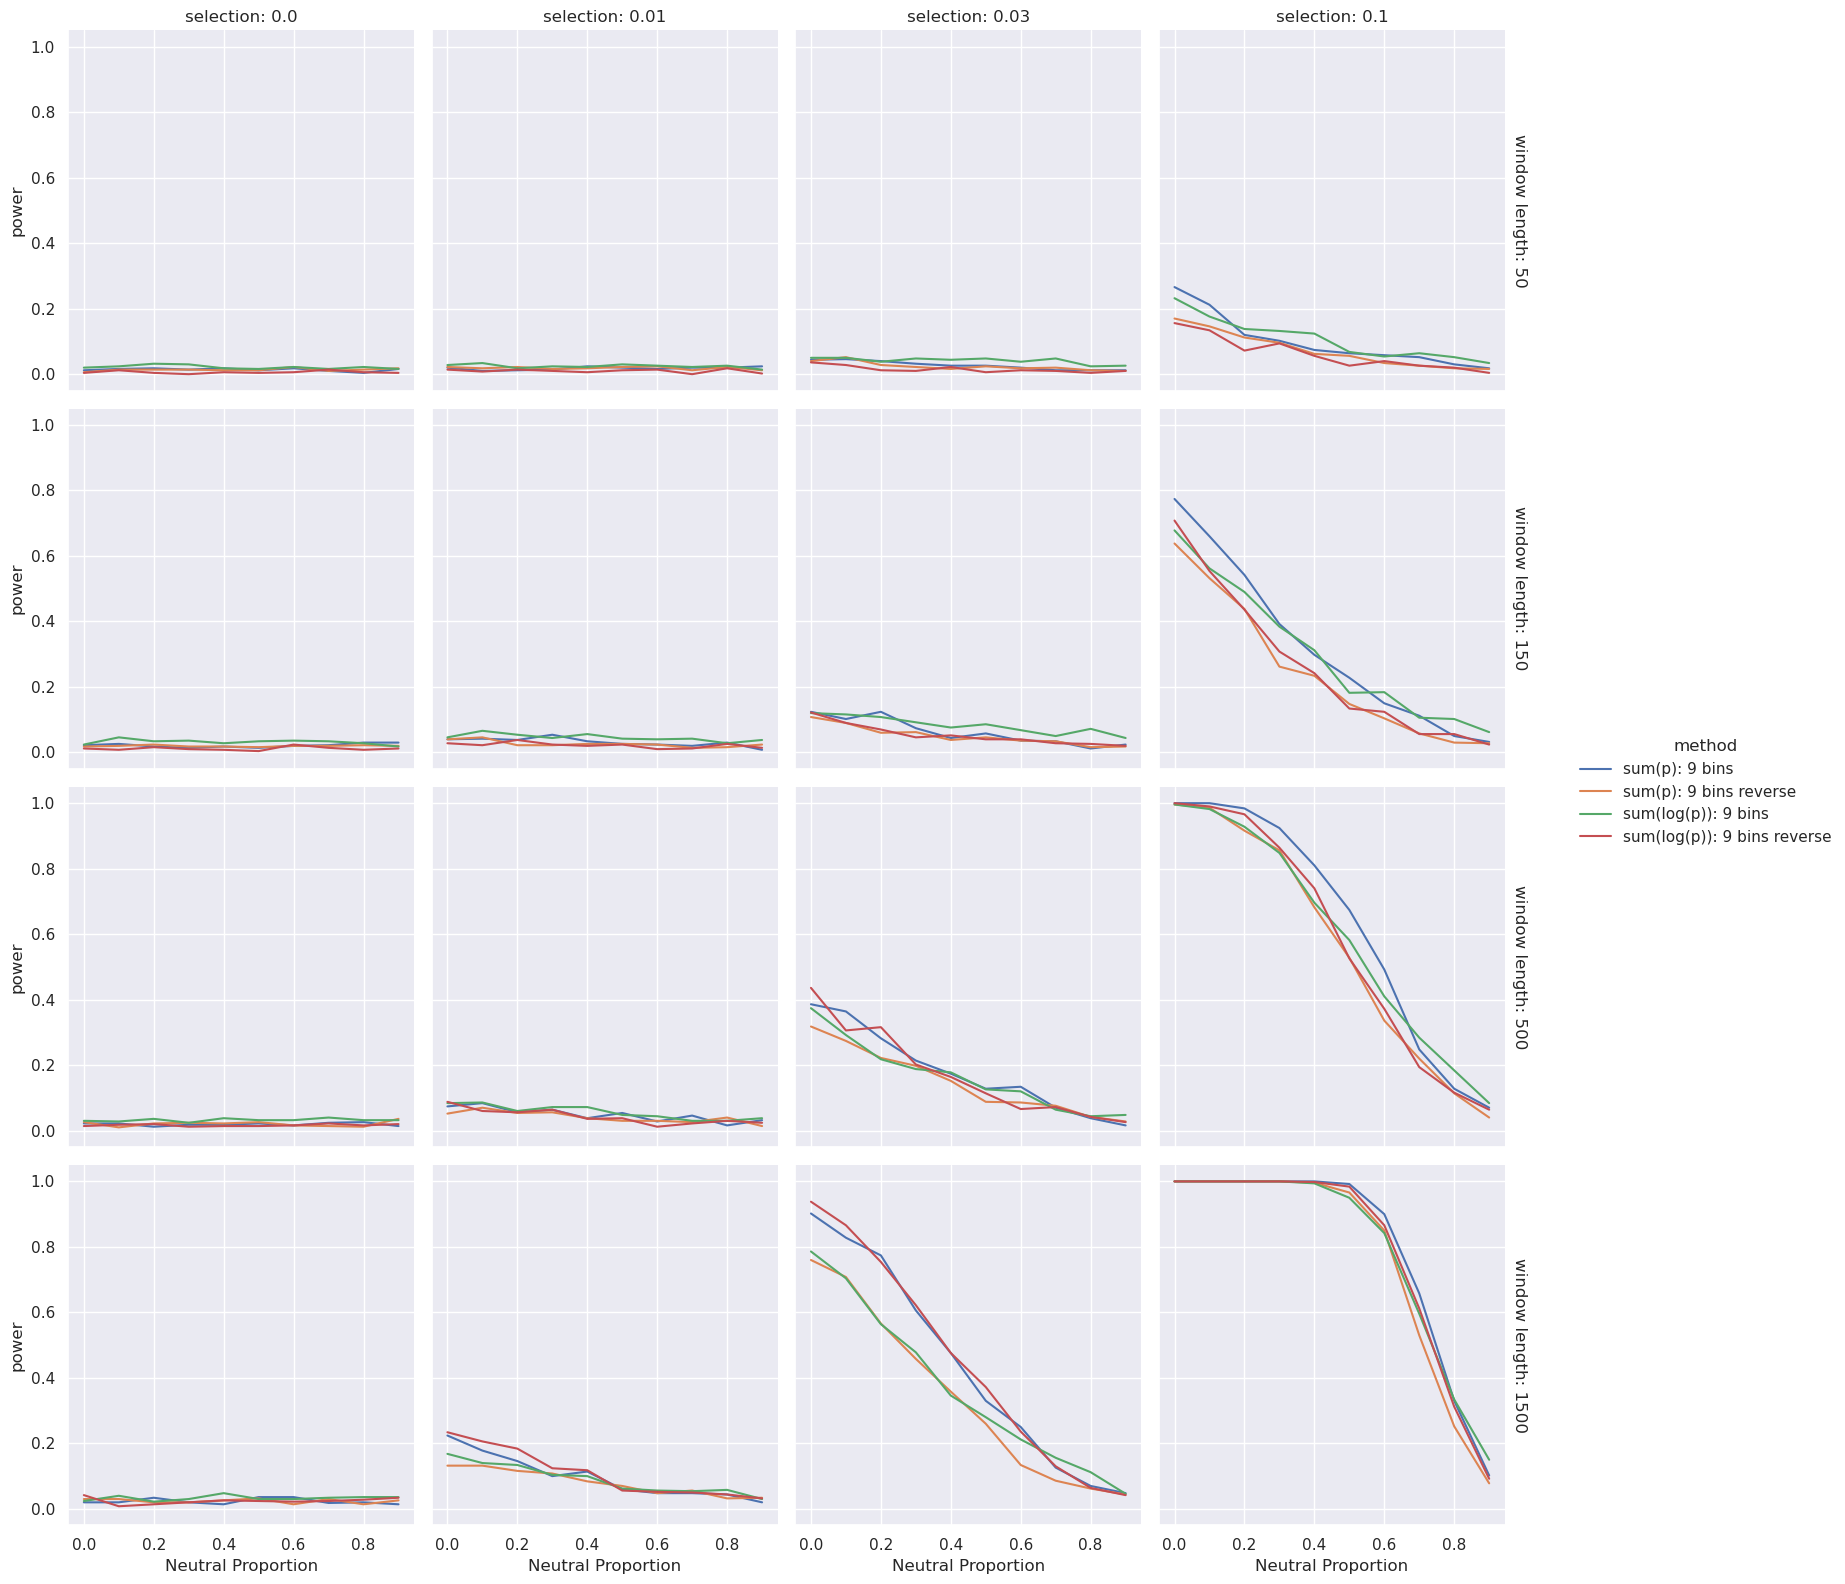

In [8]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="selection", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "Neutral Proportion", "power")

g.set_titles(col_template="selection: {col_name}", row_template="window length: {row_name}")
# g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("robustness_to_mixture_of_s_linear_9bins.svg", format="svg", bbox_inches="tight")

## 2 bins vs 9 bins reverse

In [4]:
selection_list = [0.0, 0.1, 0.03, 0.01]
# selection_list = [0.1]

window_length_list = [20, 100, 500, 2500]
# window_length_list = [20]

neutral_proportion_list = [0.1 * x for x in range(10)]
# neutral_proportion_list = [0.0]

bin_number_list = [2,9]
# bin_number_list = [2]

transformation_list = ["none", "log"]
# transformation_list = ["none"]

mu_index_list = [-1]

list_of_list_power = []
list_of_list_zscore = []

# window_length = 1000
window_num = 500

calculator_rows = [Power_Calculator(sample_size = window_num, selection=selection, mu_index = -1, bin_number = bin_number, 
                                    total_length = window_length, neutral_proportion = neutral_proportion, 
                                    transformation = transformation)
                  for window_length in window_length_list for neutral_proportion in neutral_proportion_list for selection in selection_list
                  for bin_number in bin_number_list for transformation in transformation_list]

neutral_prop_rows = [row.neutral_proportion for row in calculator_rows]
selection_rows = [row.selection for row in calculator_rows]
window_length_rows = [row.total_length for row in calculator_rows]
method_name_rows = [row.get_method_name() for row in calculator_rows]

output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(neutral_prop_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["Neutral Proportion", "selection", "window length", "method", "power"])

running analysis on window_length: 20, s: 0.0, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.0, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.0, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.0, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.1, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.1, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.1, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.1, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.03, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.03, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.03, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.03, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.01, neutral_proportion: 0.0
running analysis on window_length: 20, s: 0.01, neutral_proportion: 0.0


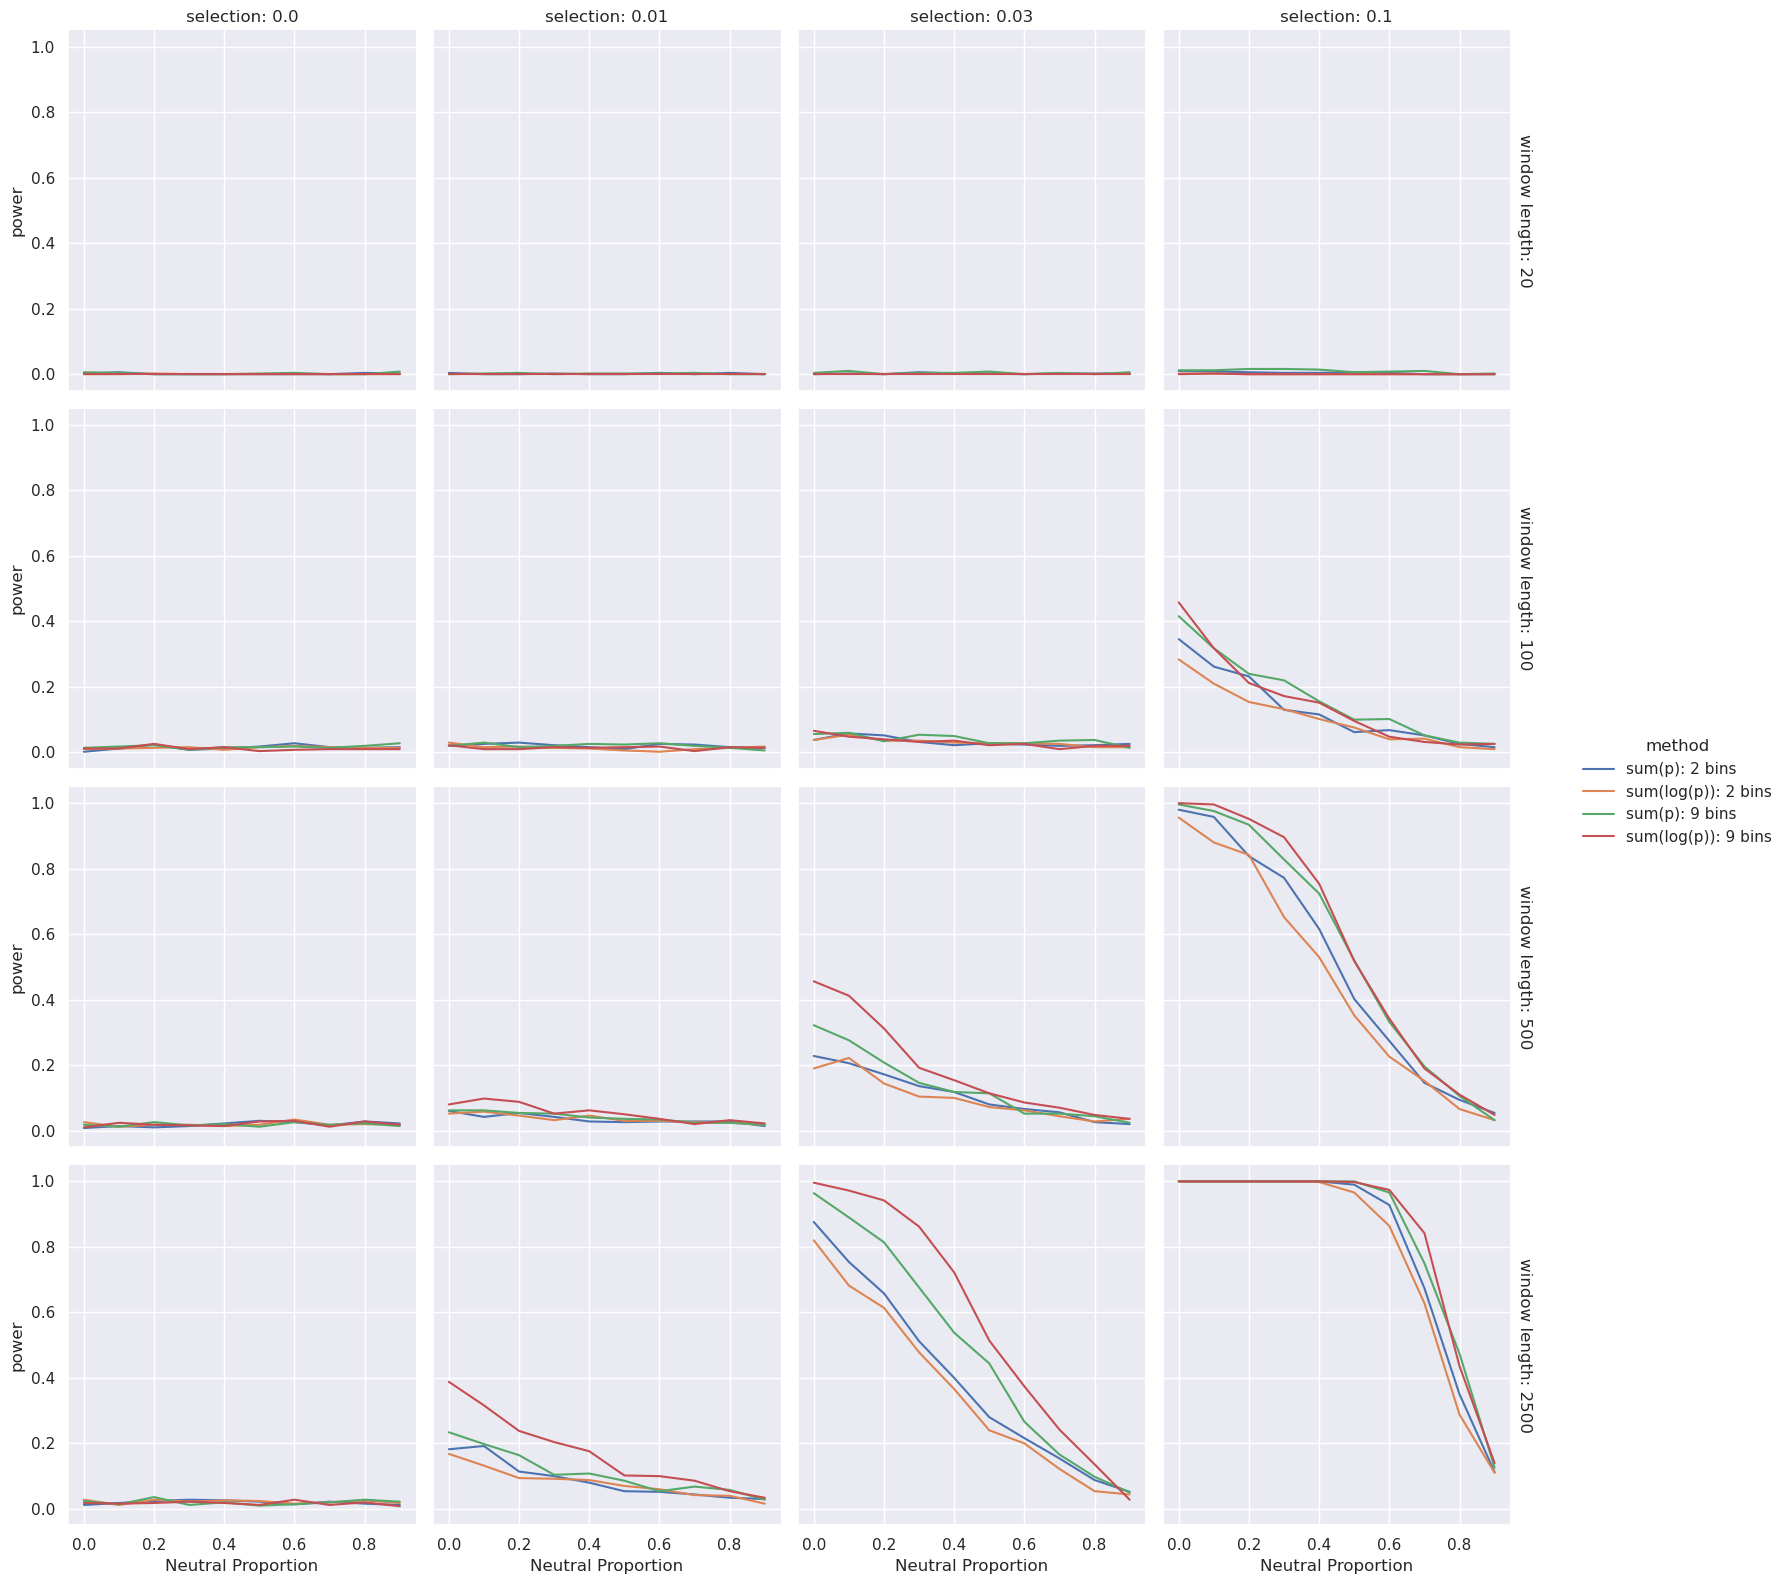

In [5]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="selection", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "Neutral Proportion", "power")

g.set_titles(col_template="selection: {col_name}", row_template="window length: {row_name}")
# g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("robustness_to_mixture_of_s_linear.svg", format="svg", bbox_inches="tight")

# S distribution, log scale of neural proportion

In [ ]:
selection_list = [0.0, 0.1, 0.03, 0.01]
# selection_list = [0.1]

window_length_list = [50, 150, 450, 1500]
# window_length_list = [20]

neutral_proportion_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.5]
# neutral_proportion_list = [0.0]

bin_number_list = [2,9]
# bin_number_list = [2]

transformation_list = ["none"]
# transformation_list = ["none"]

mu_index_list = [-1]

list_of_list_power = []
list_of_list_zscore = []

# window_length = 1000
window_num = 500

calculator_rows = [Power_Calculator(sample_size = window_num, selection=selection, mu_index = -1, bin_number = bin_number, 
                                    total_length = window_length, neutral_proportion = neutral_proportion, 
                                    transformation = transformation, reverse = False)
                  for window_length in window_length_list for neutral_proportion in neutral_proportion_list for selection in selection_list
                  for bin_number in bin_number_list for transformation in transformation_list]

neutral_prop_rows = [row.neutral_proportion for row in calculator_rows]
selection_rows = [row.selection for row in calculator_rows]
window_length_rows = [row.total_length for row in calculator_rows]
method_name_rows = [row.get_method_name() for row in calculator_rows]

output_rows = [row.calculate_power() for row in calculator_rows]
power_rows = [row[0] for row in output_rows]
zscore_rows = [row[1] for row in output_rows]

df = pd.DataFrame(zip(neutral_prop_rows, selection_rows, window_length_rows, method_name_rows, power_rows), 
                  columns = ["Neutral Proportion", "selection", "window length", "method", "power"])

running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.0
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.1
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.03
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.01
running analysis on type: cdf,  window_length: 50, s: 0.0
runnin

In [16]:
df

,Neutral Proportion,selection,window length,method,power
0,0.001,0.00,20,sum(p): 2 bins,0.000
1,0.001,0.00,20,sum(log(p)): 2 bins,0.000
2,0.001,0.00,20,sum(p): 9 bins,0.002
3,0.001,0.00,20,sum(log(p)): 9 bins,0.000
4,0.001,0.10,20,sum(p): 2 bins,0.006
...,...,...,...,...,...
443,0.500,0.03,2500,sum(log(p)): 9 bins,0.552
444,0.500,0.01,2500,sum(p): 2 bins,0.066
445,0.500,0.01,2500,sum(log(p)): 2 bins,0.050
446,0.500,0.01,2500,sum(p): 9 bins,0.086


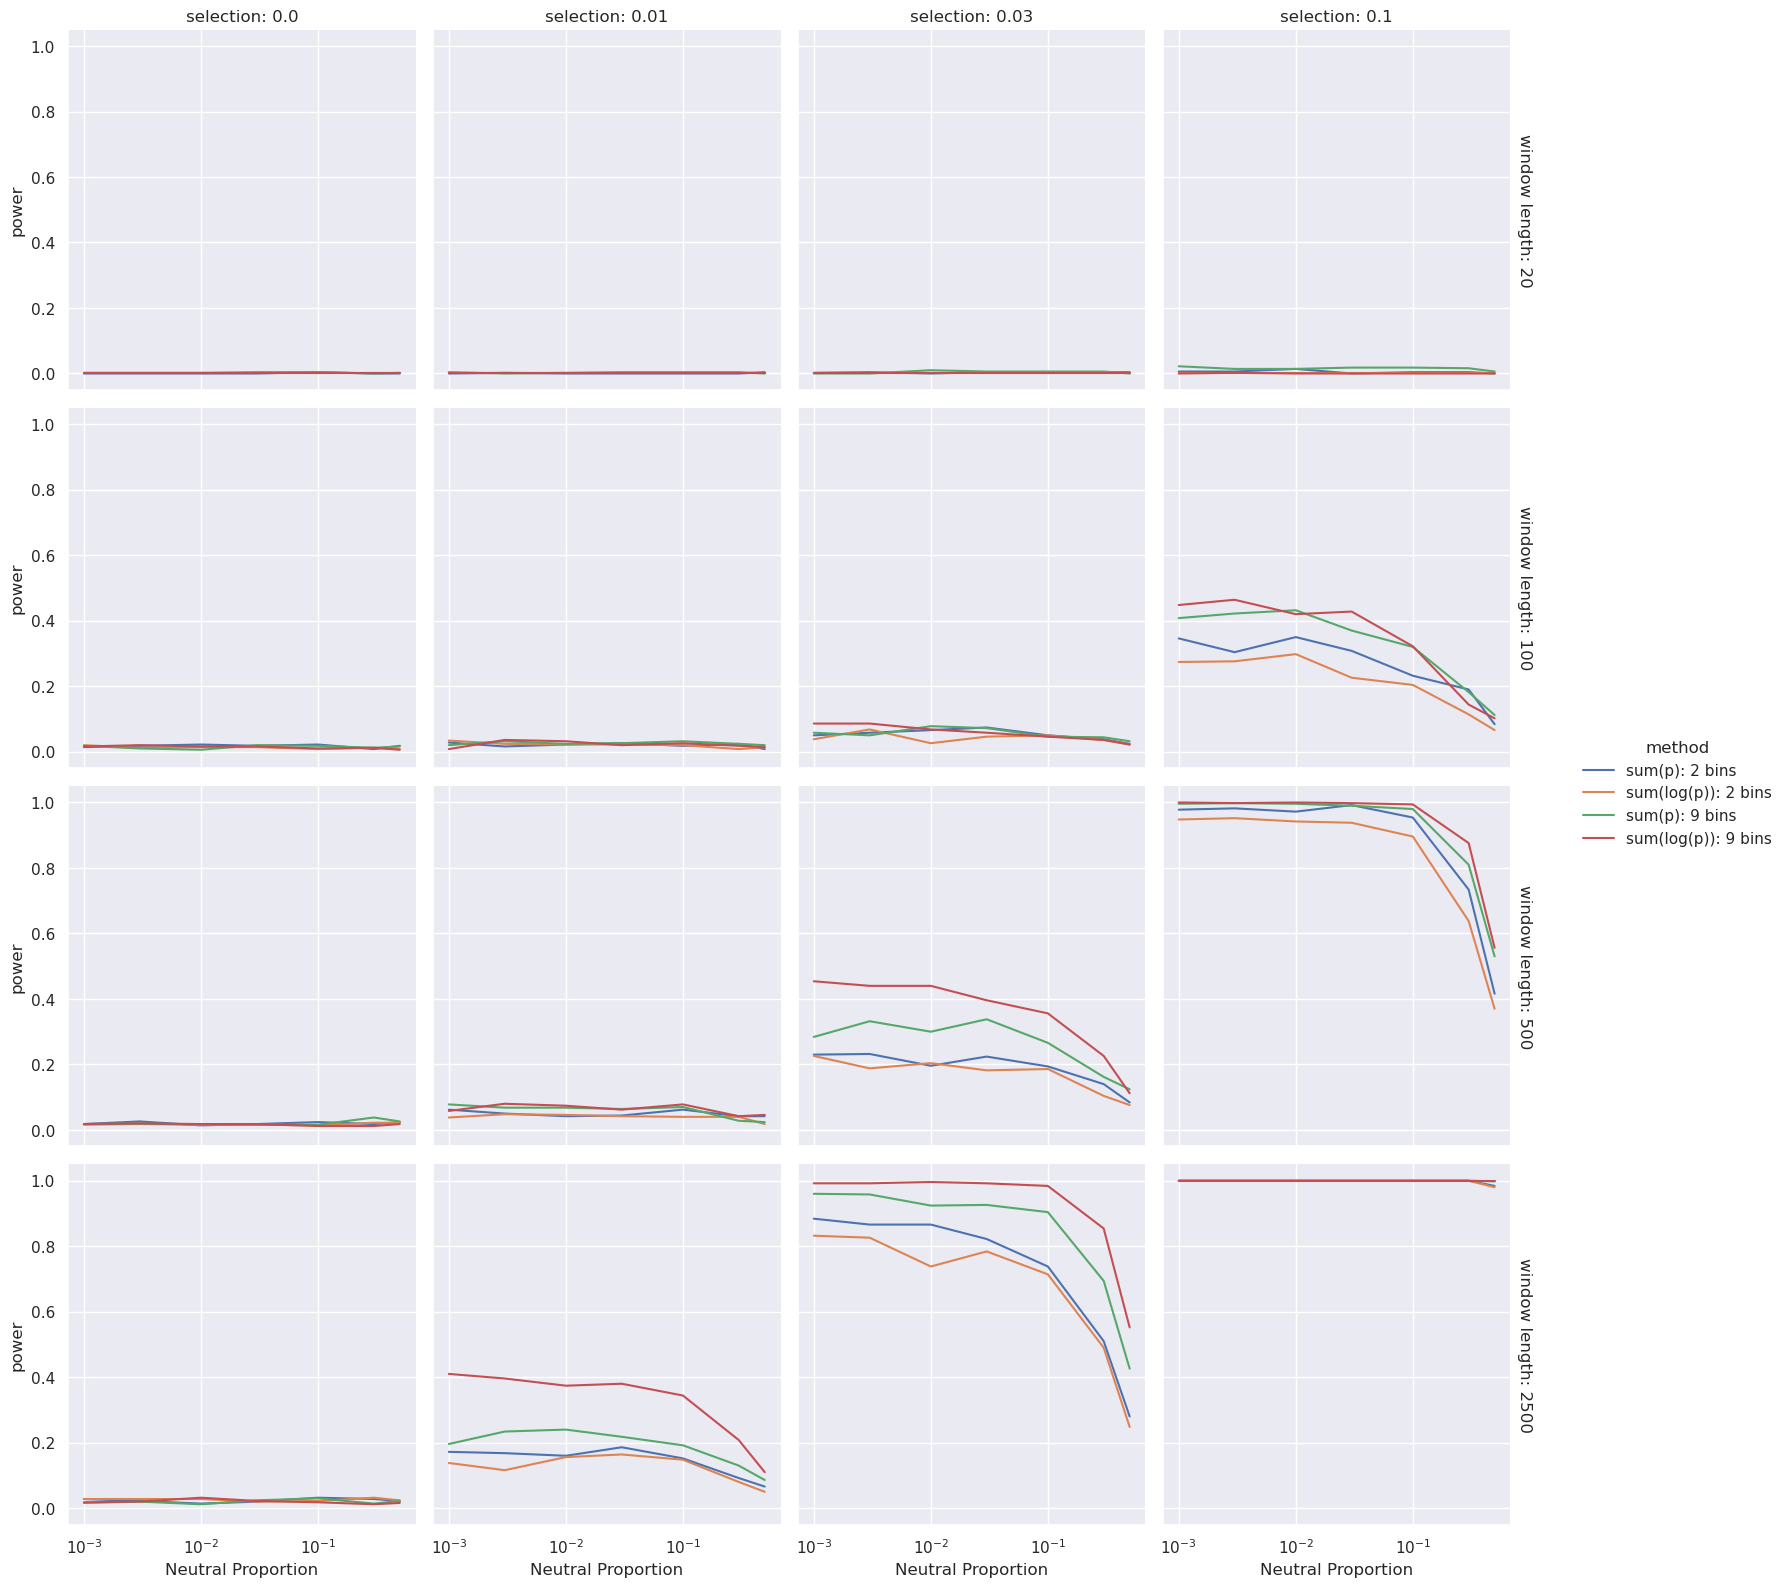

In [20]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
df_plot = df.copy()

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="selection", row="window length", height=4, margin_titles=True, hue = "method")

g.map(sns.lineplot, "Neutral Proportion", "power")

g.set_titles(col_template="selection: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("robustness_to_mixture_of_s.svg", format="svg", bbox_inches="tight")

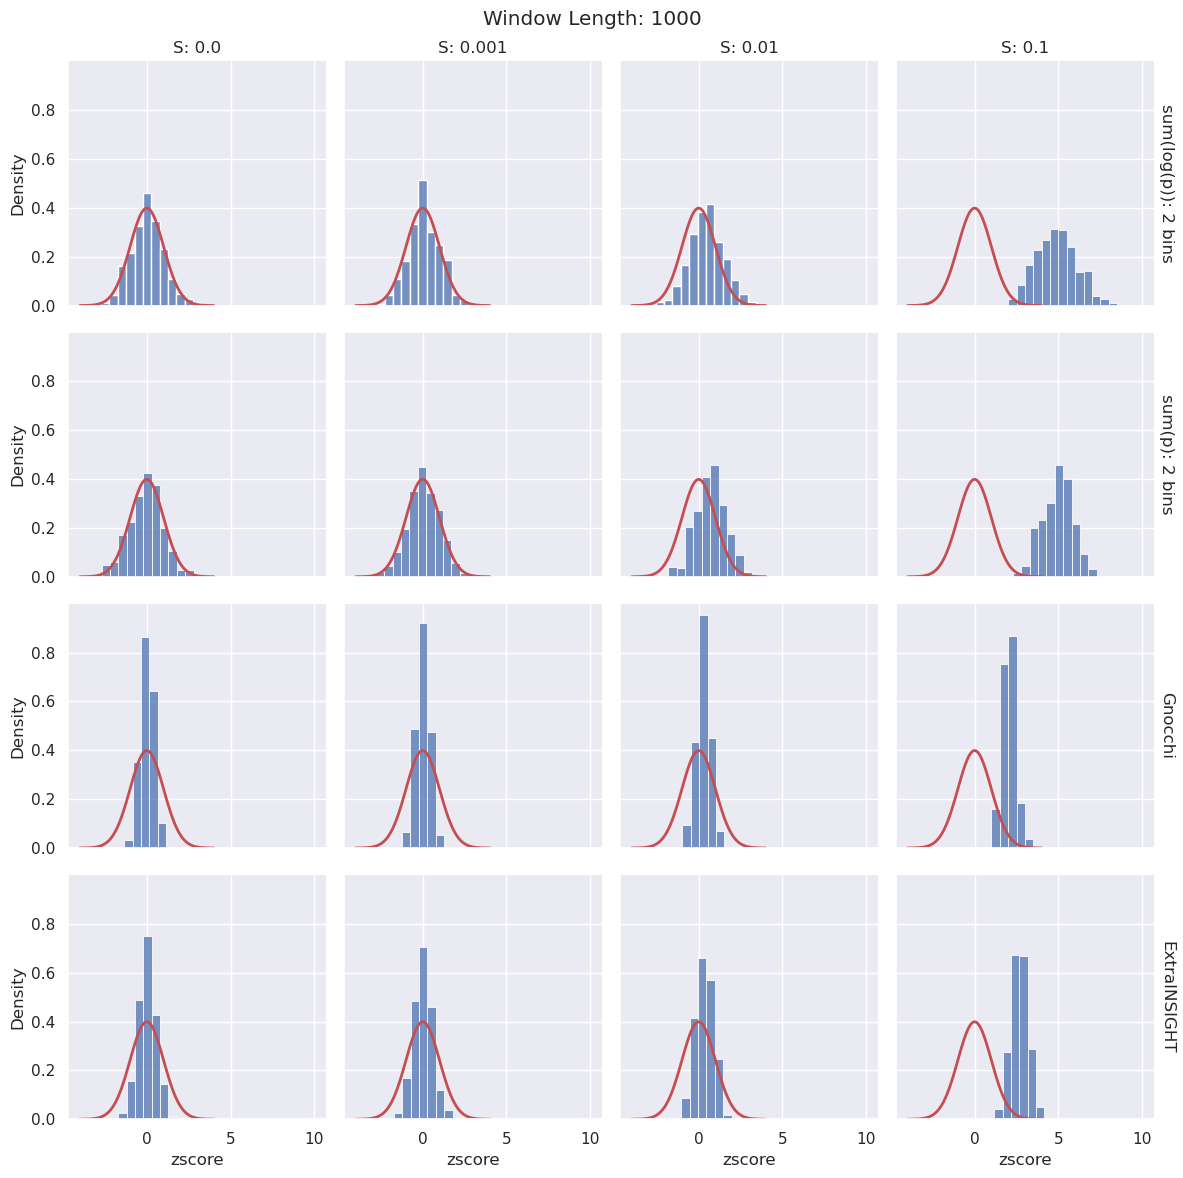

In [58]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df_zscore, col="selection", row="type", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Window Length: {window_length}')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

# plt.savefig("power_analysis_binary_zscore_plot.svg", format="svg", bbox_inches="tight")

# Compare 9 bin vs binary

## Power Analysis

In [65]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [20, 100, 500, 2500] 

list_of_list_power = []
list_of_list_zscore = []

window_num = 500

for window_length in window_length_list:
    print(window_length)
    for selection in selection_list:
        print(selection)
        for mu_index in range(-1, 5):

            for bin_num in [2, 9]:
    
                power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, 
                                                     transformation = "log", mu_index = mu_index)

                if mu_index == -1:
                    mu_name = "Empirical Distribution"
                else:
                    mu_name = mu_list[mu_index]
                
                list_of_list_power.append([power, selection, mu_name, window_length, f"sum(log(p)): {bin_num} bins"])
                for zscore in list_zscore:
                    list_of_list_zscore.append([zscore, selection, mu_name, window_length, f"sum(log(p)): {bin_num} bins"])

                
                power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, transformation = "none", 
                                                    mu_index = mu_index)
                list_of_list_power.append([power, selection, mu_name, window_length, f"sum(p): {bin_num} bins"])
                for zscore in list_zscore:
                    list_of_list_zscore.append([zscore, selection, mu_name, window_length, f"sum(p): {bin_num} bins"])
        
df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "mu", "window length", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "mu", "window length", "type"])

20
0.0
0.1
0.03
0.01
0.003
0.001
100
0.0
0.1
0.03
0.01
0.003
0.001
500
0.0
0.1
0.03
0.01
0.003
0.001
2500
0.0
0.1
0.03
0.01
0.003
0.001


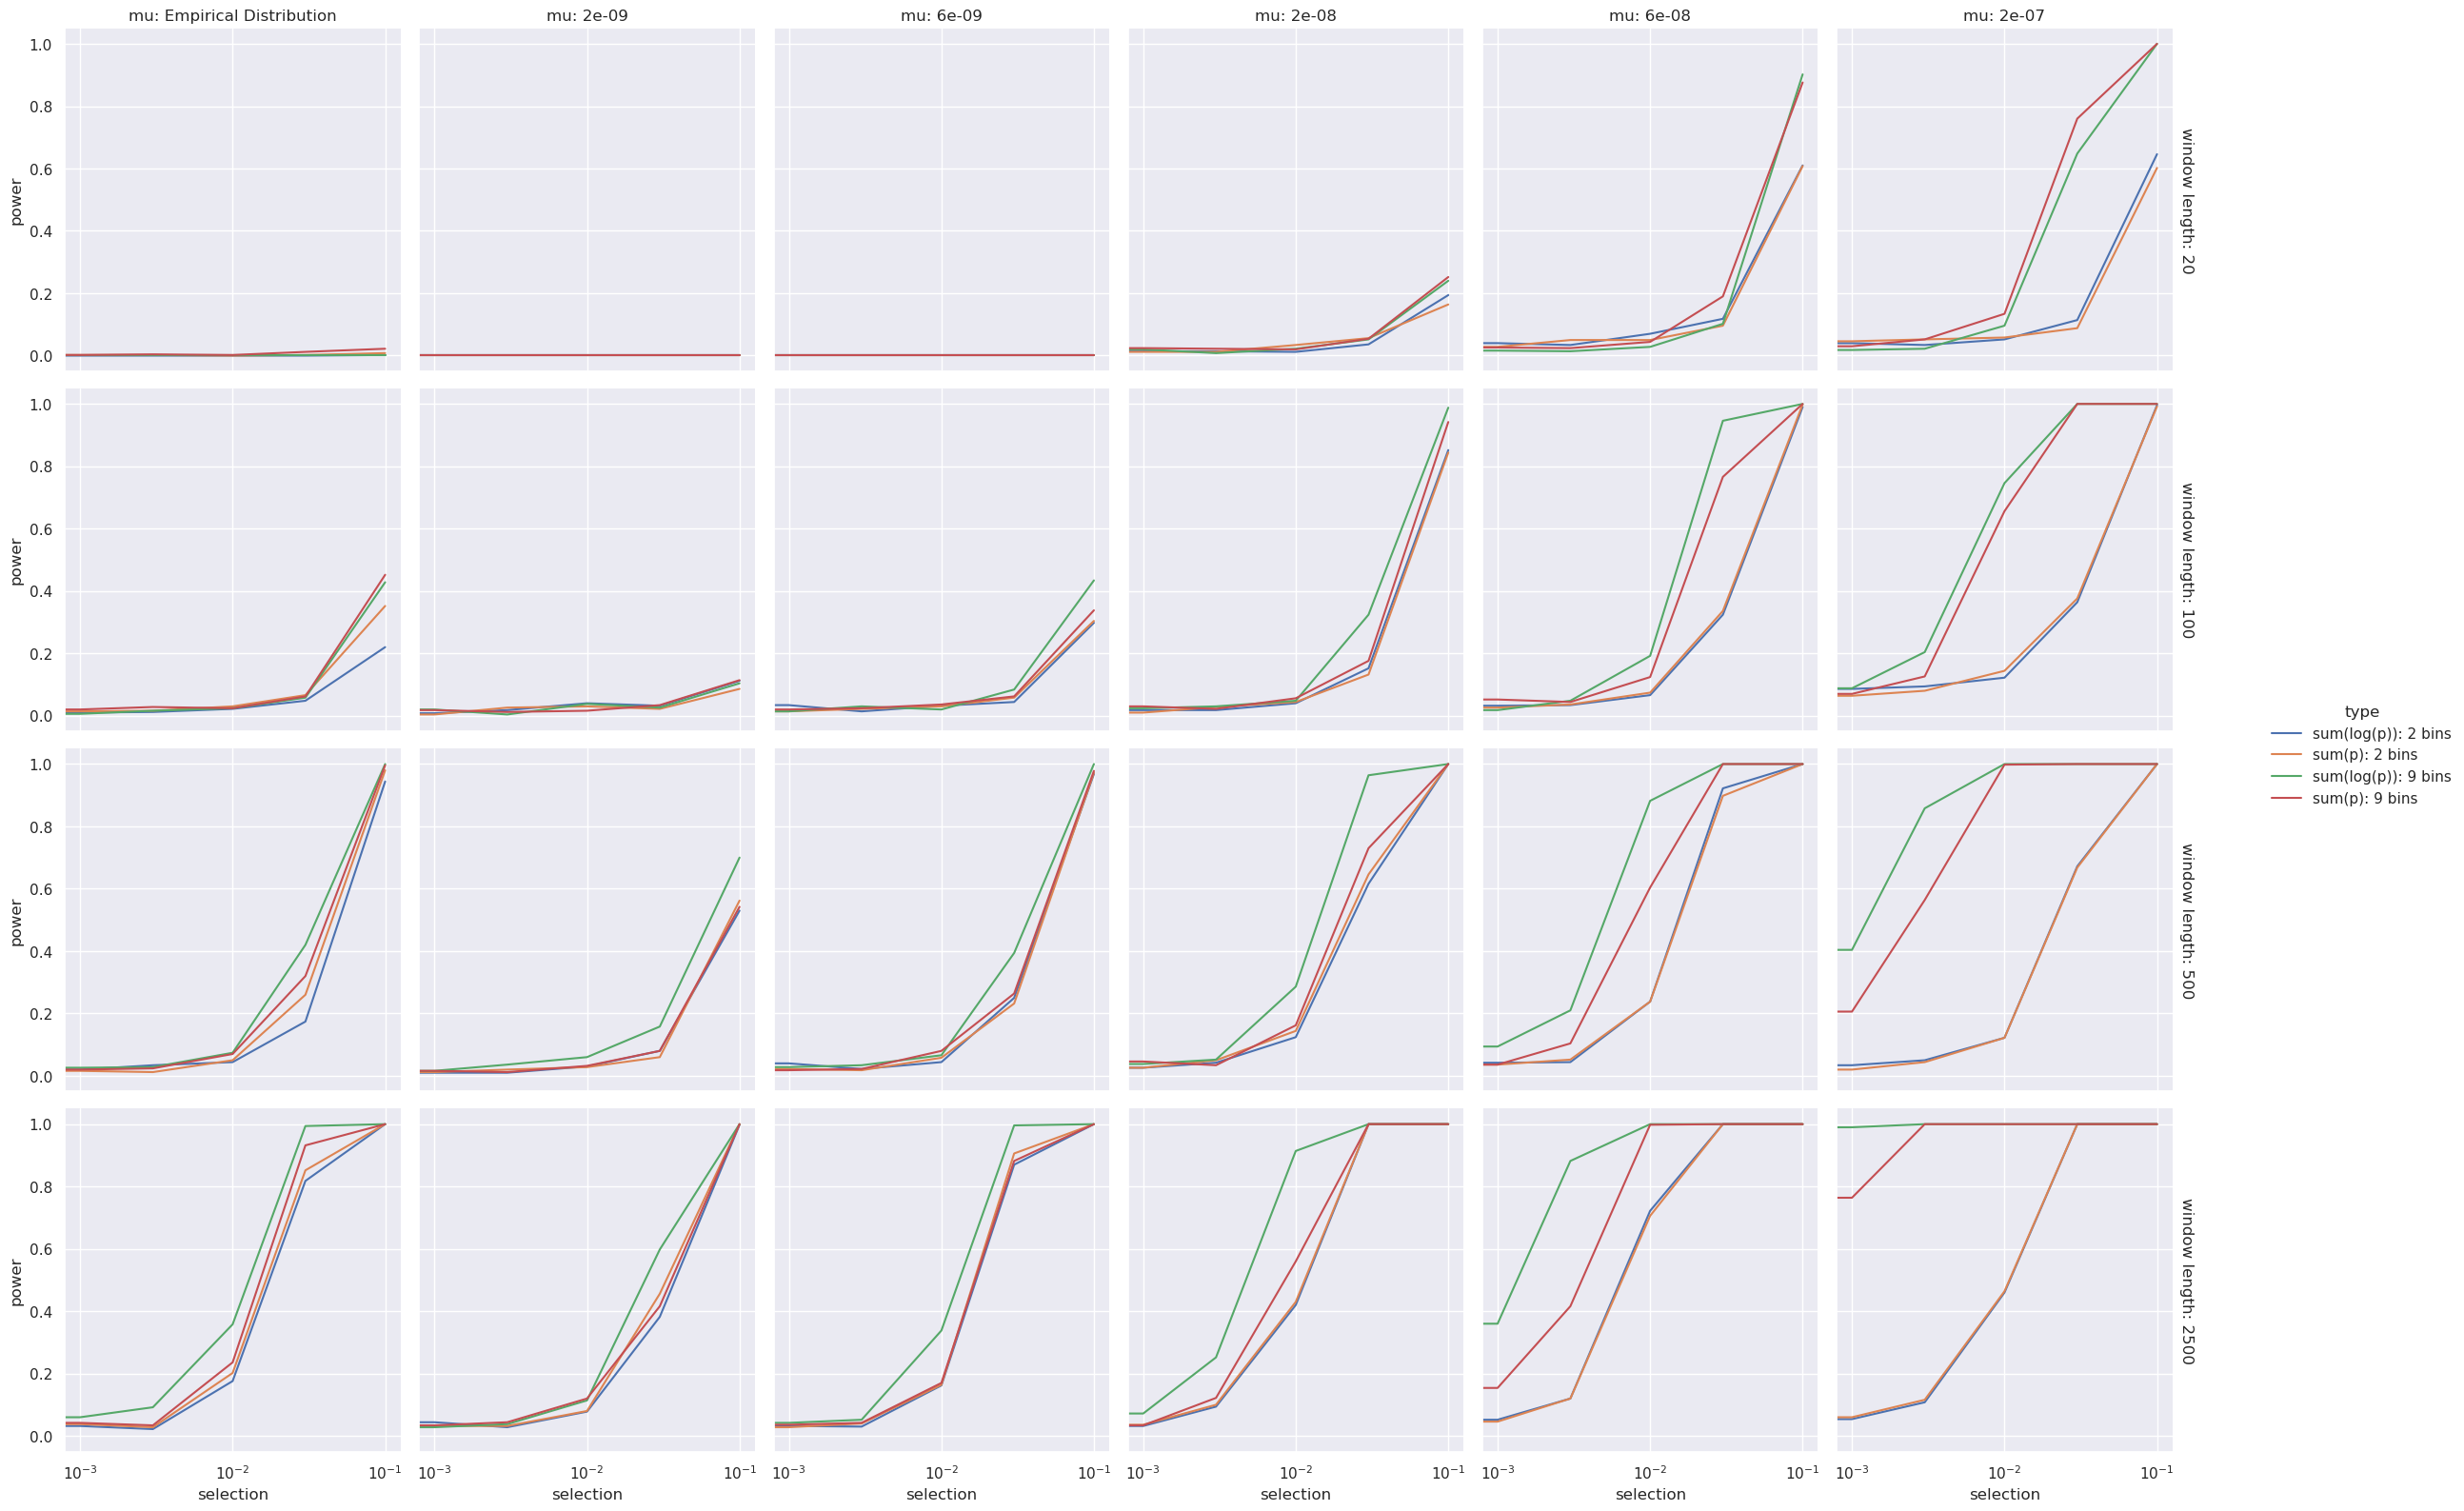

In [66]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
df_plot = df

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "type")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="mu: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_mu_windowlength.svg", format="svg", bbox_inches="tight")

## With at least two hypermutable sites

In [6]:
selection_list = [0.0, 0.1, 0.03, 0.01, 0.003, 0.001]
window_length_list = [20, 100, 500, 2500] 
mu_index_list = [-1]
hypermutable_count_list = [0, 1, 2]

list_of_list_power = []
list_of_list_zscore = []

window_num = 500

for window_length in window_length_list:
    print(window_length)
    for selection in selection_list:
        print(selection)
        for mu_index in mu_index_list:
            for bin_num in [2, 9]:
                for hypermutable_count in hypermutable_count_list:
    
                    power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, 
                                                         transformation = "log", mu_index = mu_index, hypermutable_count = hypermutable_count)
    
                    if mu_index == -1:
                        mu_name = "Empirical Distribution"
                    else:
                        mu_name = mu_list[mu_index]
                    
                    list_of_list_power.append([power, selection, mu_name, window_length, hypermutable_count, f"sum(log(p)): {bin_num} bins"])
                    for zscore in list_zscore:
                        list_of_list_zscore.append([zscore, selection, mu_name, window_length, hypermutable_count, f"sum(log(p)): {bin_num} bins"])
    
                    
                    power, list_zscore = calculate_power(window_num, 2, bin_num, selection, window_length = window_length, 
                                                         transformation = "none", mu_index = mu_index, hypermutable_count = hypermutable_count)
                    list_of_list_power.append([power, selection, mu_name, window_length, hypermutable_count, f"sum(p): {bin_num} bins"])
                    for zscore in list_zscore:
                        list_of_list_zscore.append([zscore, selection, mu_name, window_length, hypermutable_count, f"sum(p): {bin_num} bins"])
        
df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "mu", "window length", "hypermutable_count", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "mu", "window length",  "hypermutable_count", "type"])

20
0.0
0.1
0.03
0.01
0.003
0.001
100
0.0
0.1
0.03
0.01
0.003
0.001
500
0.0
0.1
0.03
0.01
0.003
0.001
2500
0.0
0.1
0.03
0.01
0.003
0.001


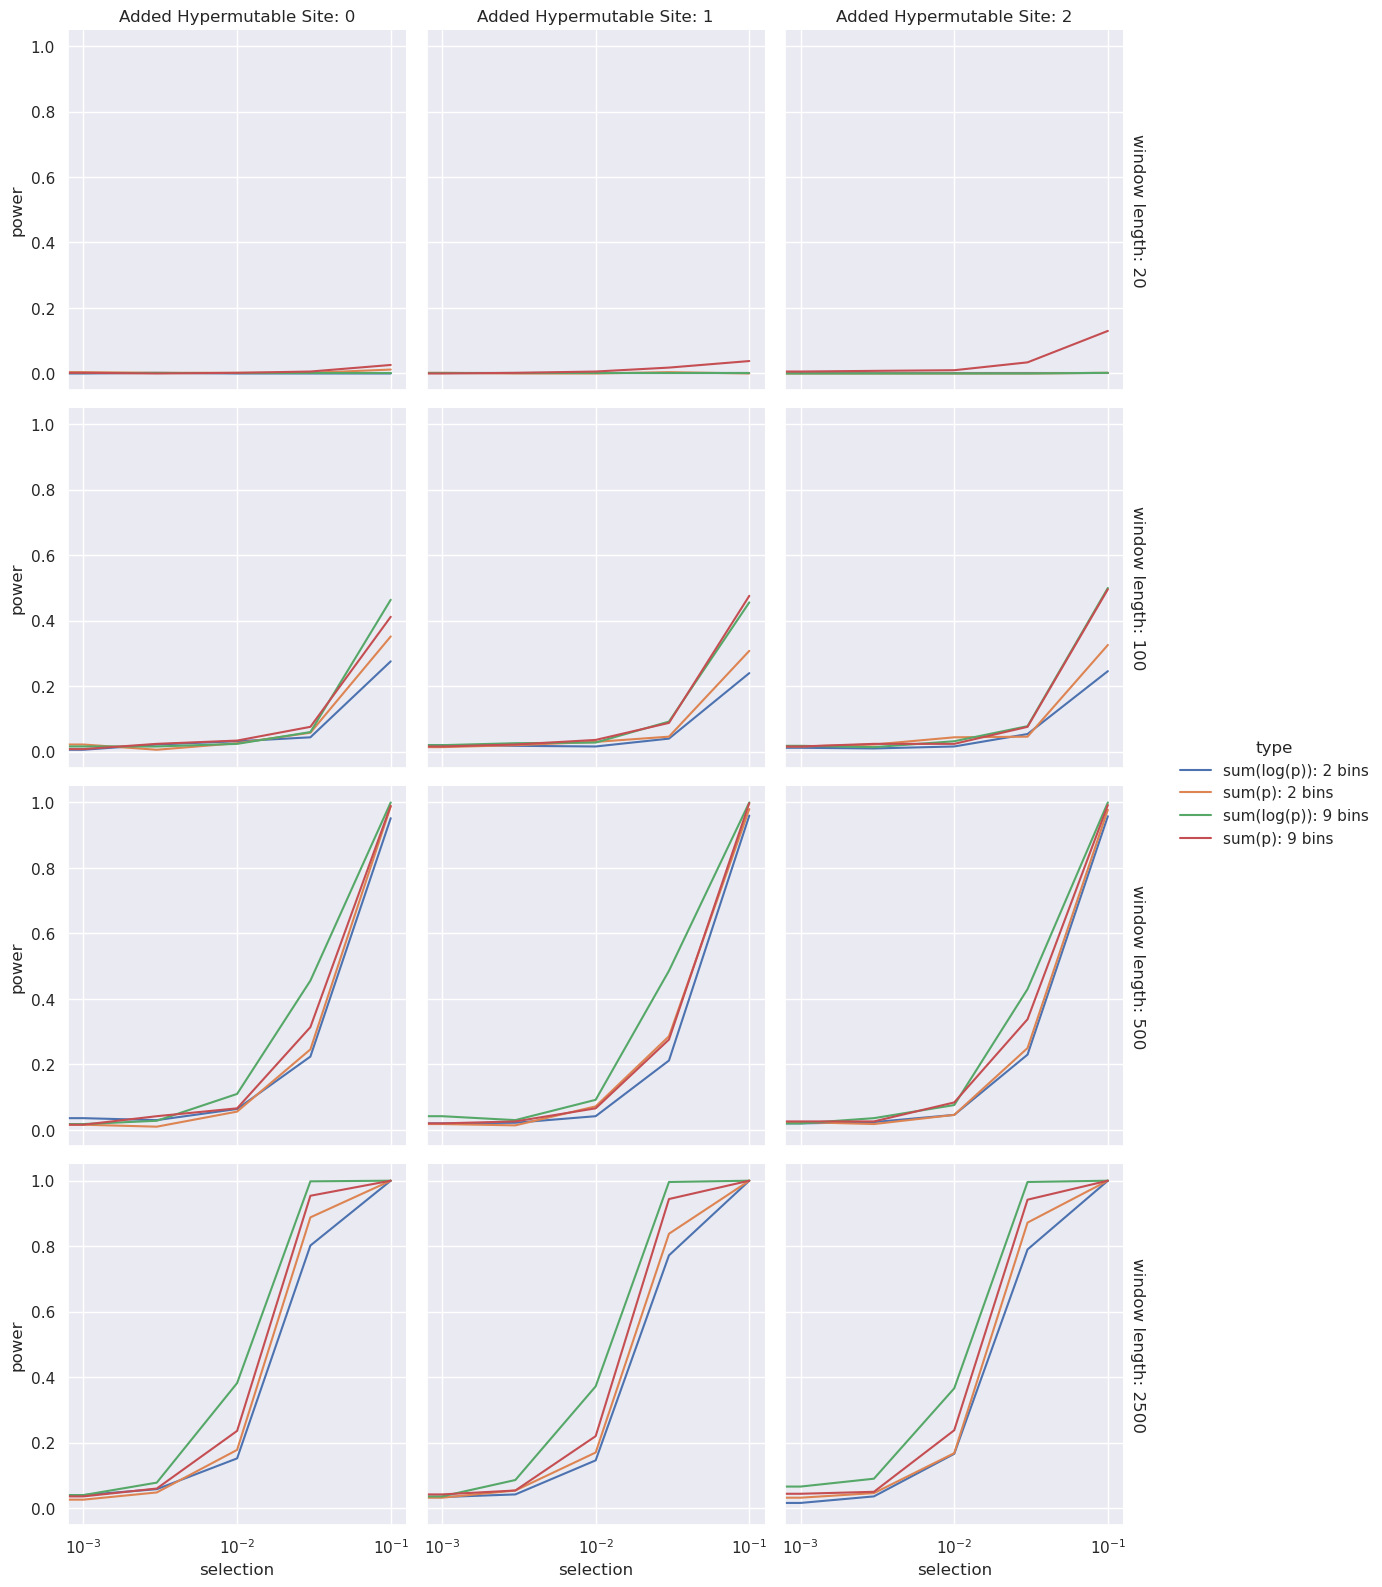

In [9]:
sns.set_theme(style="darkgrid")

# type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
# df_plot = df[df["type"].isin(type_list)]
df_plot = df

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="hypermutable_count", row="window length", height=4, margin_titles=True, hue = "type")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="Added Hypermutable Site: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_mu_windowlength_hypermutable.svg", format="svg", bbox_inches="tight")